# Задача 1. GBDT

### Data analys

In [ ]:
!pip install shap
!pip install catboost

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip "/content/drive/My Drive/HSE/w2v_recommender.zip" 

Archive:  /content/drive/My Drive/HSE/w2v_recommender.zip
   creating: w2v_recommender/
  inflating: w2v_recommender/y_w2v.pt  
  inflating: w2v_recommender/song2id.pickle  
  inflating: w2v_recommender/X_w2v.pt  
  inflating: w2v_recommender/w2v_matrix_user.npy  
  inflating: w2v_recommender/id2user.pickle  
  inflating: w2v_recommender/user2id.pickle  
  inflating: w2v_recommender/w2v_matrix_song.npy  
  inflating: w2v_recommender/id2song.pickle  


#### Вспомогательные функции 

In [ ]:
def replace_bd(table, col):
    """
    replace outliers in members['bd'] by mean value
    """
    idx = table[table[col] <= 0].index
    table_ = table.drop(idx)
    Q1 = table_[col].quantile(0.01)
    Q3 = table_[col].quantile(0.99)
    IQR = Q3 - Q1
    interval = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    mask = table_[col].between(interval[0], interval[1], inclusive=True)
    mask_bad = ~mask
    bad = table_.loc[mask_bad, col].index
    norm = table_.loc[mask, col]
    value = np.around(np.mean(norm)).astype(int)
    table.iloc[idx, 2] = [value] * len(idx)
    table.iloc[bad, 2] = [value] * bad

In [ ]:
def get_date_cols(col, name):
    """
    make 3 columns (year, month, day) from date column
    """
    result = []
    for item in col:
        item = str(item)
        year = int(item[:4])
        month = int(item[4: 6])
        day = int(item[6:])
        result.append({f'{name}_year': year, f'{name}_month': month, f'{name}_day': day})
    return pd.DataFrame(result)

In [ ]:
def split(string, first=False):
    """
    split by delimeter '|'
    """
    if pd.isnull(string):
        return string
    elif first:
        return str(string).split('|')[0]
    else:
        return str(string).split('|')

In [ ]:
def feature_importances_plot(feature_importances):
    """
    plot for feature importances
    """
    feature_importances_flatten = pd.DataFrame()
    for i in range(1, len(feature_importances.columns)-1):
        col = ['feature', feature_importances.columns.values[i]]
        feature_importances_flatten = pd.concat([feature_importances_flatten, feature_importances[col].rename(columns={f'fold_{i}': 'importance'})], axis=0)

    plt.figure(figsize=(10, 10))
    sns.barplot(data=feature_importances_flatten.sort_values(by='importance', ascending=False), x='importance', y='feature')
    plt.title('Feature Importances over {} folds'.format(5))  

### Данные

In [ ]:
members = pd.read_csv('data/members.csv')
songs = pd.read_csv('data/songs.csv')
train = pd.read_csv('data/train.csv')
songs_info = pd.read_csv('data/song_extra_info.csv')

Избавимся от выбросов в `bd`

In [ ]:
replace_bd(members, 'bd')

Делим дату на три колонки: год, месяц, день

In [ ]:
registration_init_time = get_date_cols(members.registration_init_time, 'registration_init_time')
expiration_date = get_date_cols(members.expiration_date, 'expiration_date')
members.drop(columns=['registration_init_time', 'expiration_date'], inplace=True)
members = pd.concat([members, registration_init_time, expiration_date], axis=1)

в `songs` оставляем элемент, который стоит на первом месте:

In [ ]:
songs['genre_ids'] = list(map(lambda x: split(x, first=True), songs['genre_ids']))
songs['artist_name'] = list(map(lambda x: split(x, first=True), songs['artist_name']))
songs['composer'] = list(map(lambda x: split(x, first=True), songs['composer']))
songs['lyricist'] = list(map(lambda x: split(x, first=True), songs['lyricist']))
songs = pd.merge(songs, songs_info, left_on='song_id', right_on='song_id', how='left')

In [ ]:
songs.iloc[songs[songs['language'] < 0].index] = np.nan

### Catboost

In [ ]:
data = pd.merge(train, members, left_on='msno', right_on='msno', how='left')
data = pd.merge(data, songs, left_on='song_id', right_on='song_id', how='left')

In [ ]:
y = data['target']
X = data.drop(columns=['target', 'msno', 'song_id', 'isrc'])

In [ ]:
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

In [ ]:
categorical_features_indices = X.select_dtypes(include=['category']).columns

In [ ]:
params = {
    'random_seed': 42,
    'task_type': 'GPU',
    'max_depth': 8,
    'learning_rate': 0.1,
    'custom_metric': 'AUC',
    'eval_metric': 'AUC',
    'l2_leaf_reg': 3.5,
    'bagging_temperature': 0.9,
    'iterations': 100
}

In [ ]:
def train_cat(X, y, cat_features):
    kf = KFold(n_splits=5)
    fold_splits = kf.split(X, y)
    scores = []

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    for i, (dev_index, val_index) in enumerate(fold_splits):
        dev_X, val_X = X.iloc[dev_index], X.iloc[val_index]
        dev_y, val_y = y.iloc[dev_index], y.iloc[val_index]
        
        model = CatBoostClassifier(**params)
        
        print(f'Fold {i + 1}')
        fit_model = model.fit(dev_X, dev_y,
                            eval_set=(val_X, val_y),
                            use_best_model=True,
                            cat_features=cat_features,
                            verbose=20,
                            plot=False)
        feature_imp = fit_model.feature_importances_
        feature_importances[f'fold_{i + 1}'] = feature_imp
        pred = fit_model.predict(val_X)
        auc = roc_auc_score(val_y, pred)
        scores.append(auc)

    return scores, feature_importances

In [ ]:
scores, feature_importances = train_cat(X, y, categorical_features_indices)

Fold 1
0:	learn: 0.6470241	test: 0.7134627	best: 0.7134627 (0)	total: 166ms	remaining: 16.5s
20:	learn: 0.6659917	test: 0.7295032	best: 0.7295032 (20)	total: 3.01s	remaining: 11.3s
40:	learn: 0.6696959	test: 0.7316509	best: 0.7316509 (40)	total: 5.76s	remaining: 8.29s
60:	learn: 0.6731050	test: 0.7336724	best: 0.7336724 (60)	total: 8.5s	remaining: 5.43s
80:	learn: 0.6759249	test: 0.7355511	best: 0.7355511 (80)	total: 11.2s	remaining: 2.63s
99:	learn: 0.6787584	test: 0.7372237	best: 0.7372237 (99)	total: 13.8s	remaining: 0us
bestTest = 0.7372237146
bestIteration = 99
Fold 2
0:	learn: 0.6670648	test: 0.6737318	best: 0.6737318 (0)	total: 169ms	remaining: 16.7s
20:	learn: 0.6836255	test: 0.6885893	best: 0.6885893 (20)	total: 3.02s	remaining: 11.4s
40:	learn: 0.6873863	test: 0.6915684	best: 0.6915684 (40)	total: 5.8s	remaining: 8.35s
60:	learn: 0.6906184	test: 0.6940999	best: 0.6940999 (60)	total: 8.51s	remaining: 5.44s
80:	learn: 0.6929491	test: 0.6958176	best: 0.6958176 (80)	total: 11.2s	

In [ ]:
for i in range(len(scores)):
    print(f'Fold {i + 1}: AUC on validations - {scores[i]}')
print(f'Mean AUC - {np.mean(scores)}')

Fold 1: AUC on validations - 0.6831616893918708
Fold 2: AUC on validations - 0.6493681405076202
Fold 3: AUC on validations - 0.6265901861377441
Fold 4: AUC on validations - 0.6040459391759547
Fold 5: AUC on validations - 0.5889205792675886
Mean AUC - 0.6304173068961557


Я искренне пыталась использовать shap, но у меня постоянно умирал kernel :(

In [ ]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train, approximate=True)

In [ ]:
feature_importances['mean'] = np.mean(feature_importances.drop(columns='feature').values, axis=1)

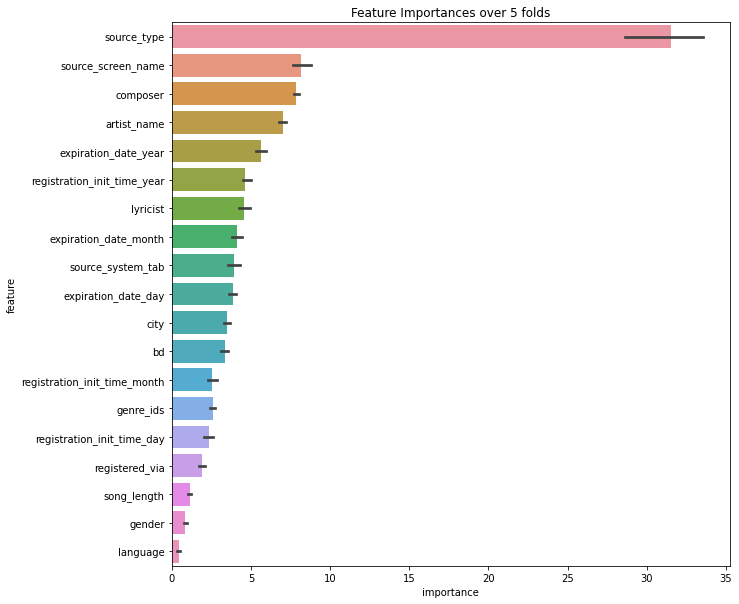

In [ ]:
feature_importances_plot(feature_importances)

На самом деле все получившиеся фичи более менее значимы, для эксперимента возьмем топ-10 фичей

In [ ]:
col_names = list(feature_importances.sort_values(by='mean', ascending=False).head(10)['feature'])
X_ = X[col_names]
categorical_features_indices_2 = X_.select_dtypes(include=['category']).columns

In [ ]:
scores_2, feature_importances_2 = train_cat(X_, y, categorical_features_indices_2)

Fold 1
0:	learn: 0.6474861	test: 0.7129377	best: 0.7129377 (0)	total: 157ms	remaining: 15.5s
20:	learn: 0.6652148	test: 0.7290276	best: 0.7290938 (19)	total: 2.85s	remaining: 10.7s
40:	learn: 0.6680113	test: 0.7304652	best: 0.7304652 (40)	total: 5.38s	remaining: 7.74s
60:	learn: 0.6698220	test: 0.7313224	best: 0.7313313 (58)	total: 7.88s	remaining: 5.04s
80:	learn: 0.6715907	test: 0.7322388	best: 0.7322388 (80)	total: 10.4s	remaining: 2.43s
99:	learn: 0.6728239	test: 0.7327144	best: 0.7327178 (98)	total: 12.7s	remaining: 0us
bestTest = 0.7327177823
bestIteration = 98
Shrink model to first 99 iterations.
Fold 2
0:	learn: 0.6670501	test: 0.6735997	best: 0.6735997 (0)	total: 164ms	remaining: 16.2s
20:	learn: 0.6825539	test: 0.6879905	best: 0.6879905 (20)	total: 2.8s	remaining: 10.5s
40:	learn: 0.6854281	test: 0.6900906	best: 0.6900906 (40)	total: 5.36s	remaining: 7.71s
60:	learn: 0.6873139	test: 0.6914778	best: 0.6914778 (60)	total: 7.87s	remaining: 5.03s
80:	learn: 0.6890463	test: 0.6925

In [ ]:
for i in range(len(scores_2)):
    print(f'Fold {i + 1}: AUC on validations - {scores_2[i]}')
print(f'Mean AUC - {np.mean(scores_2)}')

Fold 1: AUC on validations - 0.6810395038464121
Fold 2: AUC on validations - 0.6478508057428557
Fold 3: AUC on validations - 0.6250662914062615
Fold 4: AUC on validations - 0.6027881980932036
Fold 5: AUC on validations - 0.5869840810801575
Mean AUC - 0.6287457760337781


Так как сильно неважных фичей не было AUC не улучшился от выбрасывания наименее важных фичей.

# Задача 2. Неклассические эмбеддинги

В качестве неклассических эмбеддингов будем использовать w2v песен

In [2]:
from tqdm.notebook import tqdm
from gensim.models import Word2Vec 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def not_china(texts):
    """
    to detect korean/japanese/chinese hieroglyphs
    """
    # korean
    if re.search("[\uac00-\ud7a3]", texts):
        return False
    # japanese
    if re.search("[\u3040-\u30ff]", texts):
        return False
    # chinese
    if re.search("[\u4e00-\u9FFF]", texts):
        return False
    return True

In [ ]:
songs.dropna(subset=['artist_name'], inplace=True)

Для каждого пользователя выберем треки, которые он слушал (будем рассматривать в качестве сессии)

In [ ]:
group = data.groupby('msno')
sessions = {}
for user in data['msno'].unique():
    sessions[user] = list(group.get_group(user)['song_id'].values)

Обучим word2vec

In [ ]:
w2v = Word2Vec(window=5,
                 negative=10,
                 min_count=0,
                 workers=20,
                 size=100,
                 seed=42)

sentences = list(sessions.values())

In [ ]:
w2v.build_vocab(sentences, progress_per=200)
w2v.train(sentences, total_examples = w2v.corpus_count, 
            epochs=10, report_delay=1)

(73774180, 73774180)

In [ ]:
# w2v = Word2Vec.load('word2vec2.model')

In [ ]:
def similar_song(id_, filtering=False, top=5):
    """
    get similar songs by song_id
    filtering=True returns only european songs
    """
    vector = w2v[id_]
    similar = w2v.similar_by_vector(vector, topn=top + 5)[1:]
        
    result = pd.DataFrame()
    for song, score in similar:
        row = songs[songs['song_id'] == song]
        row['score'] = score
        if filtering and not_china(row['artist_name'].values[0]) or not filtering: 
            result = result.append(row)            
    return result[:top] 

### a) Similars

Симилары для Selena Gomez

In [ ]:
i = 'S/BQuJmY8py2c1eqQVqnfdnOx1d2o5mTJ4BGkQgt9Pg='
print('Query:')
display(songs[songs['song_id'] == i])
print('Similars:')
similar_song(i, filtering=True)

Query:


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
1500,S/BQuJmY8py2c1eqQVqnfdnOx1d2o5mTJ4BGkQgt9Pg=,239537.0,465,Selena Gomez,Toby Gad,NaN,52.0,A Year Without Rain,USHR11132698


Similars:


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,score
1446093,FwcBk+GbQiVR3b9yQXFZqSQ8Bpaeb7F2t1T69C4hhAY=,176021.0,359,Walk The Moon,Nicholas Petricca,Nicholas Petricca,52.0,Work This Body,USRC11402587,0.901673
2244827,5pmv1SUttiszbjKt9NNpj8VkeL/rAVxWiUai51UhR7M=,227648.0,465,Gwen Stefani,Gwen Stefani,NaN,52.0,Used To Love You,USUM71516915,0.893781
1391254,h8wiXJ3SCR/AdZUSpCR5eajvNE/yMsEdXoCsJ4jM660=,228623.0,465,CHARLI XCX,NaN,NaN,52.0,Doing It (feat. Rita Ora),GBAHS1500002,0.880087
1361,eydL6gNMRr1sGOCAh88skRkTPVKCBRtQfQBQYxIn4KE=,203871.0,465,Nick Jonas,Jason Evigan,NaN,52.0,Chains,USUM71411120,0.879425
173006,qvIitcIqScpR7nxkIXn08PWM5a1Hx1ms5roMLF/sAiw=,238329.0,465,Jessica Sanchez,NaN,NaN,52.0,Tonight,QMTM61300011,0.879060


Симиляры для Eminem

In [ ]:
i = 'p+WxS35GIo9lHYpW17Bz/PRW+UcGH9R+bq+wU2caYnY='
print('Query:')
display(songs[songs['song_id'] == i])
print('Similars:')
similar_song(i, filtering=True)

Query:


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
1381,p+WxS35GIo9lHYpW17Bz/PRW+UcGH9R+bq+wU2caYnY=,326426.0,1259,Eminem,Jeff Bass,NaN,52.0,Lose Yourself,USIR10211559


Similars:


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,score
218128,mQiuYoYa7M4AXaoBIdnsYdWsQvdxO4+iOLEJDPH2uHA=,248081.0,1259,Eminem,Marshall Mathers,NaN,52.0,Not Afraid,USUM71011769,0.843304
111270,OOarkaG0Xyy2XApXZH6fhr4MYYEHpff1PehLT+beSSo=,303717.0,1259,Eminem,Marshall Mathers,NaN,52.0,Cold Wind Blows,USUM71015400,0.828991
148617,4vR/NlFbW5kLlBr/m0ZoWEUJaaf7KBWhHL6n28EcZlg=,363903.0,1259,Eminem,Marshall Mathers,NaN,52.0,Rap God,USUM71314079,0.819325
210085,78w25Ysgx+7z9JWQwlA3ypIpPvKBz6afDGLnp1OZUcw=,250125.0,1259,Eminem,Marshall Mathers,NaN,52.0,The Monster,USUM71314082,0.804873
477730,7DV7pn2Z7mB/RGbPIlnSQa4j204CBWSOcjYcz4n36GI=,404375.0,465,Eminem,Marshall Mathers,NaN,52.0,Stan,USIR10001280,0.795895


### б) Recommendations

In [4]:
import torch
import torch.nn as nn
import pickle
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Модель:

In [6]:
class Embeddings(nn.Module):
    def __init__(self, embeddings_path):
        super(Embeddings, self).__init__()
        embeddings = np.load(embeddings_path)
        self.v_s, self.d_model = embeddings.shape

        self.embeddings = nn.Embedding(self.v_s, self.d_model)
        self.embeddings.weight = nn.Parameter(
            torch.from_numpy(embeddings).float(), requires_grad=False
        )
    
    def forward(self, x):
        return self.embeddings(x)

In [8]:
class Recommender_w2v(nn.Module):
    def __init__(self, emb_path_song, emb_path_user, hidden_size=32): 
        super().__init__()
        self.song_embeddings = Embeddings(emb_path_song)
        self.user_embeddings = Embeddings(emb_path_user)

        self.fc1 = nn.Linear(self.song_embeddings.d_model * 2, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, 1)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        user = self.user_embeddings(x[:, 0, :])
        song = self.song_embeddings(x[:, 1, :])
        embeddings = torch.cat([user, song], dim=2)

        # print('emb:', embeddings.shape)
        x = self.fc1(embeddings)
        # print('f1:', x.shape)
        x = self.relu(x)
        # print('relu:', x.shape)
        x = self.fc2(x)
        # print('f2:', x.shape)
        x = self.Sigmoid(x)
        # print('sig:', x.shape)
        return x

In [9]:
matrix = np.array([w2v.wv[piece] for piece in w2v.wv.vocab])
np.save(f'w2v_matrix.npy', matrix)

Эмбеддинги для пользователей

In [ ]:
def get_user_embeddings(user_id):
    return np.mean([w2v[s] for s in sessions[user_id]], axis=0)

In [ ]:
users = {item: get_user_embeddings(item) for item in tqdm(data['msno'].unique())}
matrix = np.array([users[piece] for piece in users.keys()])
np.save(f'w2v_matrix_user.npy', matrix)

In [ ]:
user2id = {x: i for i, x in enumerate(users.keys())}
id2user = list(users.keys())

In [ ]:
song2id = {x: i for i, x in enumerate(w2v.wv.vocab)}
id2song = list(w2v.wv.vocab)

In [ ]:
X_ = []
for i, (user, song) in tqdm(data[['msno', 'song_id']].iterrows(), total=len(data)):
    u = user2id[user]
    s = song2id[song]
    X_.append([u, s])

Загрузка данных:

In [9]:
# X_w2v = torch.tensor(X_)
# torch.save(X_w2v, 'X_w2v.pt')
X_w2v = torch.load('w2v_recommender/X_w2v.pt', map_location=torch.device(device))

In [10]:
# y_w2v = torch.tensor(data['target'].to_list())
# torch.save(y_w2v, 'y_w2v.pt')
y_w2v = torch.load('w2v_recommender/y_w2v.pt', map_location=torch.device(device))

In [11]:
with open('w2v_recommender/user2id.pickle', 'rb') as f:
    user2id = pickle.load(f)

with open('w2v_recommender/id2user.pickle', 'rb') as f:
    id2user = pickle.load(f)
    
with open('w2v_recommender/song2id.pickle', 'rb') as f:
    song2id = pickle.load(f)

with open('w2v_recommender/id2song.pickle', 'rb') as f:
    id2song = pickle.load(f)

Train

In [56]:
def train_recommender_w2v(X, y):
    X = X.unsqueeze(2)
    y = y.unsqueeze(1).type(torch.FloatTensor)

    kf = KFold(n_splits=5)
    fold_splits = kf.split(X, y)
    scores = []

    for i, (dev_index, val_index) in enumerate(fold_splits):
        dev_X, val_X = X[dev_index], X[val_index]
        dev_y, val_y = y[dev_index], y[val_index]
        
        model = Recommender_w2v('w2v_recommender/w2v_matrix_song.npy', 'w2v_recommender/w2v_matrix_user.npy')
        model = model.to(device)
        
        train = TensorDataset(dev_X, dev_y)
        val = TensorDataset(val_X, val_y)

        train_data = DataLoader(train, batch_size=512, shuffle=True)
        val_data = DataLoader(val, batch_size=512, shuffle=True)

        optimizer = Adam(model.parameters())
        criterion = nn.BCELoss()
        epochs = 10
        losses = []

        print(f'Fold {i + 1}')
        for e in tqdm(range(epochs)):
            for xx, yy in train_data:
                model.train()
                optimizer.zero_grad()
                y_pred = model(xx)
                loss = criterion(y_pred.flatten(0, 1).cpu(), yy.cpu())
                loss_value = loss.item()
                loss.backward()
                optimizer.step()

            if e % 5 == 0 or e == epochs - 1: 
                for x_, y_ in val_data: 
                    with torch.no_grad():
                        model.eval()
                        y_val_pred = model(x_)
                        loss = criterion(y_val_pred.flatten(0, 1).cpu(), y_.cpu())
                        losses.append(loss.item())
                print(f'Loss {e + 1} / {epochs}: {np.mean(losses)}')

        with torch.no_grad():
            model.eval()
            y_result = model(val_X)
            auc = roc_auc_score(val_y.cpu(), y_result.flatten(0, 1).cpu())
        scores.append(auc)
    return scores

In [58]:
scores = train_recommender_w2v(X_w2v, y_w2v)

Fold 1


Loss 1 / 10: 0.6497827474232104
Loss 6 / 10: 0.6484118635293761
Loss 10 / 10: 0.6461745838986043

0.7015429969737472
Fold 2


Loss 1 / 10: 0.6478524991905086
Loss 6 / 10: 0.6449275229392492
Loss 10 / 10: 0.6441980658610497

0.6795233234422824
Fold 3


Loss 1 / 10: 0.6664443667525636
Loss 6 / 10: 0.6611078700553535
Loss 10 / 10: 0.6592053802179402

0.6606400193795328
Fold 4


Loss 1 / 10: 0.6768074252181877
Loss 6 / 10: 0.6736789443875915
Loss 10 / 10: 0.671193666461439

0.6432210748501956
Fold 5


Loss 1 / 10: 0.6820587827710953
Loss 6 / 10: 0.6850417198239723
Loss 10 / 10: 0.6846530685236187

0.6272458801751584


In [59]:
for i in range(len(scores)):
    print(f'Fold {i + 1}: AUC on validations - {scores[i]}')
print(f'Mean AUC - {np.mean(scores)}')

Fold 1: AUC on validations - 0.7015429969737472
Fold 2: AUC on validations - 0.6795233234422824
Fold 3: AUC on validations - 0.6606400193795328
Fold 4: AUC on validations - 0.6432210748501956
Fold 5: AUC on validations - 0.6272458801751584
Mean AUC - 0.6624346589641832


Модель с word2vec фичами оказалась лучше (у catboost mean AUC 0.63), но это видимо из-за того что в первом варианте были выбраны не очень хорошие фичи